<a href="https://colab.research.google.com/github/nunocesarsa/GoogleColab_public/blob/master/GP_Augmentation_OVPGrass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing packages

In [80]:
#General purpose: 
#plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#data management
import pandas as pd
import numpy
import numpy as np

#Gaussian processes
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel, ExpSineSquared, RationalQuadratic, RBF

#model evaluation from sklearn
from sklearn import metrics

#a few more stuff for random
import random as rdm
import math

Generating a GP model call that is customizable. This helps to create more lean loops but is somewhat unecessary.

In [3]:
#gaussian processes with default acquisition function
#initializing the gaussian process -optimized
K_ratQ = RationalQuadratic(length_scale_bounds="fixed",alpha_bounds="fixed")
K_RBF = RBF(length_scale_bounds="fixed")

def gpr_call():
  mdl = GaussianProcessRegressor(kernel=K_RBF,
                                 n_restarts_optimizer=80, # -> 1*RBF(1.0) is the default kernel
                                 normalize_y=True,
                                 alpha=.05)
#with 0 alpha, crazy results

                                 #alpha=.001)
                                 #alpha=.05)
  return mdl
  

Loading the csv file

In [68]:
#filepath="/content/drive/My Drive/Leon/Leon_Data_Montesinho.csv"
filepath="/content/drive/My Drive/OVP_Grass/Table_data/input_data.csv"

#for portuguese type CSV
#field_data = pd.read_csv(filepath,sep=";",decimal=",")
#for other types
field_data = pd.read_csv(filepath,sep=",",decimal=".")
#field_data

Removing NA values

In [69]:
corr_df = field_data.dropna()
print(field_data.shape)
print(corr_df.shape)

field_data=corr_df


(1607, 20)
(1576, 20)


Selecting target and explanatory variables

In [70]:
tgt_trait= "Grass height"
tgt_trait_2 = "Grass cover"

#selecting the trait and indices only
sel_df = field_data[[tgt_trait,tgt_trait_2,
                     "NDVI","EVI","RATIO",
                     "SAVI","TVI","NDWI",
                     "NDTI","RDVI","BLUE",
                     "GREEN","NIR","MIR",
                     "SWIR2"]]
                  
#sel_df


Creating a 70/30 partition - NOT K-fold validation

In [71]:
#generating an index to randomly select n rows. 
index = list(range(len(sel_df)))
index30 = rdm.sample(index,math.ceil(len(index)*.3)) #randomly selects 10% of te data (aproximately)
index70 = [x for x in index if x not in index10] #makes a list with the remaining
#index90
#index10

#subsetting the pd frames
tr_df = sel_df.iloc[index70,:]
vl_df = sel_df.iloc[index30,:]

#listing all items
feat_names = list(sel_df.columns)[2:]
tgt_names = list(sel_df.columns)[:2]

Looping

In [75]:
vl_var_np.shape


,NDVI
0,0.846597
1,0.620531
3,0.387805
4,0.470206
5,0.690485
...,...
1598,0.860465
1600,0.766371
1603,0.690527
1604,0.786044


------------------------------------------------------------
Trained using: NDVI
MAE hgt: 2.700783698736472


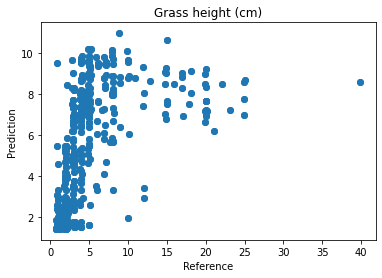

MAE cvr: 0.10808608206604657


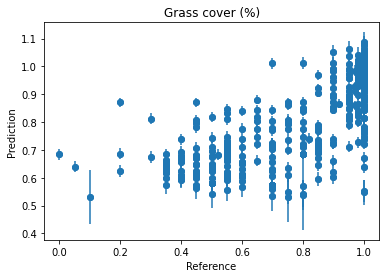

------------------------------------------------------------
------------------------------------------------------------
Trained using: EVI
MAE hgt: 2.6621023598929914


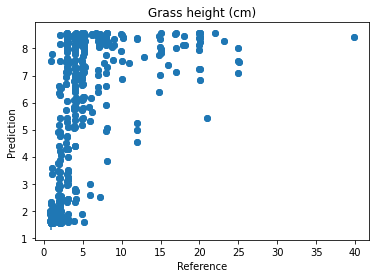

MAE cvr: 0.09237507462331362


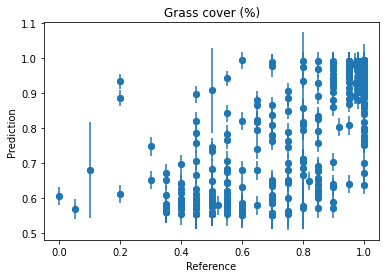

------------------------------------------------------------
------------------------------------------------------------
Trained using: RATIO
MAE hgt: 2.5843031060451076


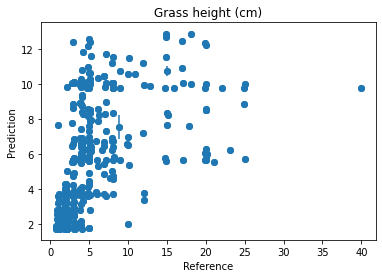

MAE cvr: 0.09023238136294699


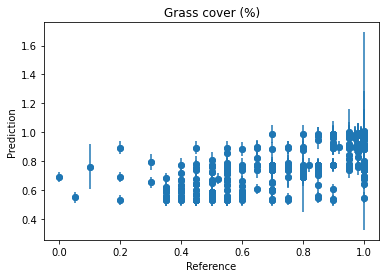

------------------------------------------------------------
------------------------------------------------------------
Trained using: SAVI
MAE hgt: 2.6852818881475153


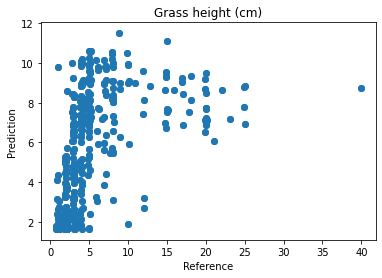

MAE cvr: 0.1016393449379493


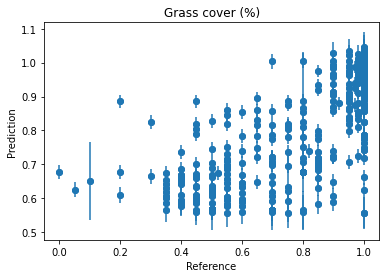

------------------------------------------------------------
------------------------------------------------------------
Trained using: TVI
MAE hgt: 2.838642633560398


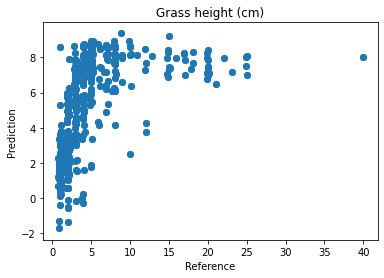

MAE cvr: 0.1081751933549138


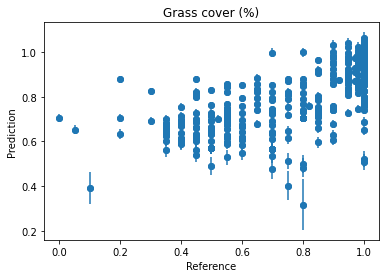

------------------------------------------------------------
------------------------------------------------------------
Trained using: NDWI
MAE hgt: 2.885440551793879


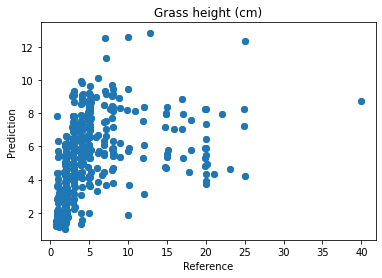

MAE cvr: 0.13002712704856662


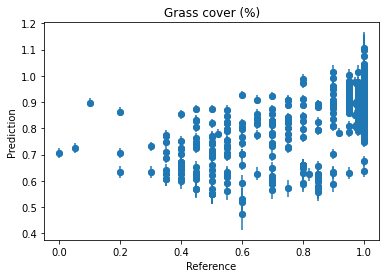

------------------------------------------------------------
------------------------------------------------------------
Trained using: NDTI
MAE hgt: 2.7697169611789483


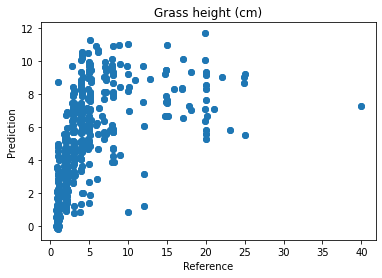

MAE cvr: 0.12758467743362065


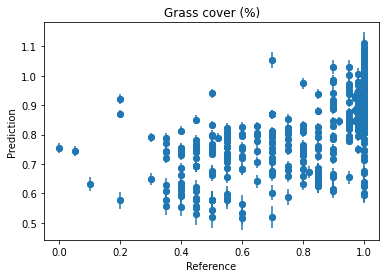

------------------------------------------------------------
------------------------------------------------------------
Trained using: RDVI
MAE hgt: 2.951833340374059


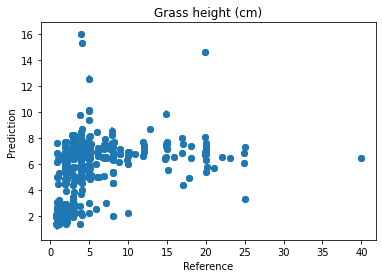

MAE cvr: 0.10208358008639036


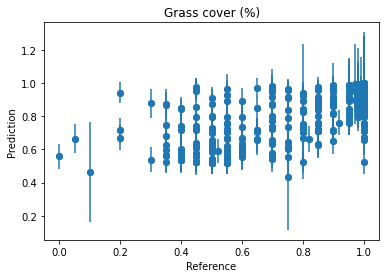

------------------------------------------------------------
------------------------------------------------------------
Trained using: BLUE
MAE hgt: 3.048347657641275


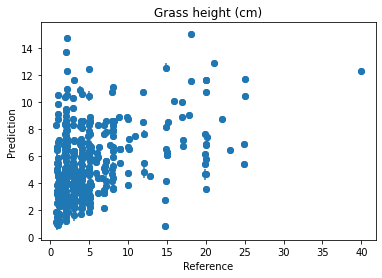

MAE cvr: 0.1487742191555794


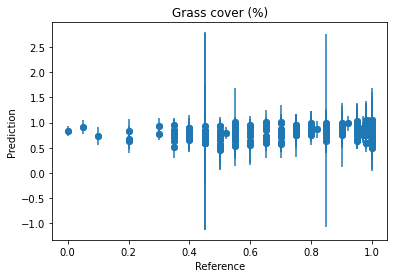

------------------------------------------------------------
------------------------------------------------------------
Trained using: GREEN
MAE hgt: 2.547959596792301


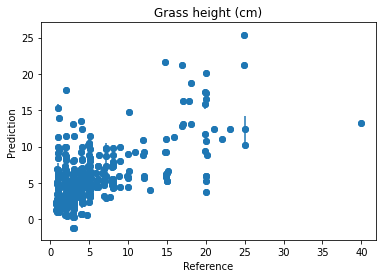

MAE cvr: 0.1308822106253943


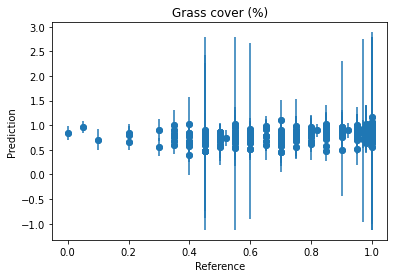

------------------------------------------------------------
------------------------------------------------------------
Trained using: NIR
MAE hgt: 2.0752582308116163


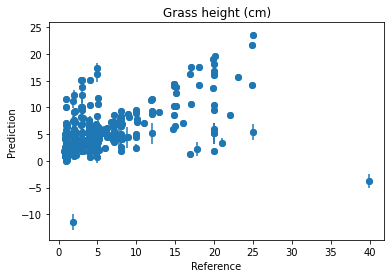

MAE cvr: 0.0893274978037746


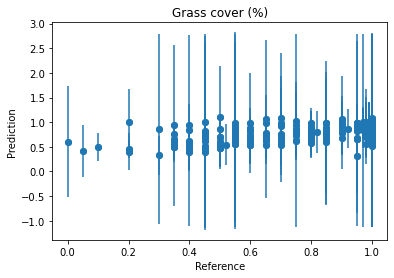

------------------------------------------------------------
------------------------------------------------------------
Trained using: MIR
MAE hgt: 2.403922048105002


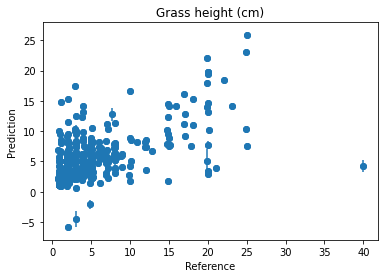

MAE cvr: 0.10613242886025194


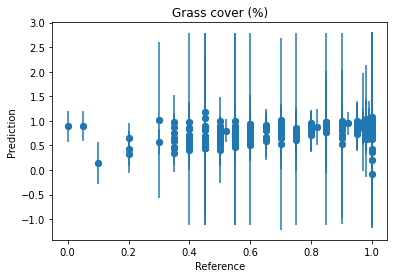

------------------------------------------------------------
------------------------------------------------------------
Trained using: SWIR2
MAE hgt: 2.5684870848874746


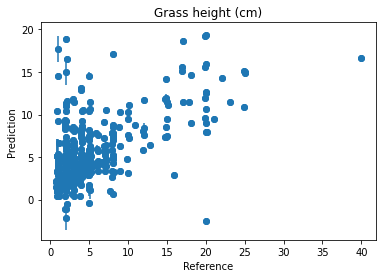

MAE cvr: 0.1265436444021135


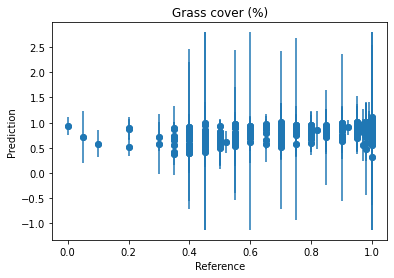

------------------------------------------------------------


In [96]:

#making a numpy of the target variables (validation)
vl_tgt_df = vl_df[[tgt_trait,tgt_trait_2]]
vl_tgt_np = vl_tgt_df.iloc[:,:].values

#making a numpy of the target variables (training)
tr_tgt_df = tr_df[[tgt_trait,tgt_trait_2]]
tr_tgt_np = tr_tgt_df.iloc[:,:].values

for i in feat_names:

  #selecting the feature used for fitting
  var_tmp_df = tr_df[[i]]

  #tranforming to numpy array
  var_tmp_np = var_tmp_df.iloc[:,:].values
  
  #initating the GP
  gpr_mdl = gpr_call()

  #training the GPR
  gpr_mdl.fit(var_tmp_np,tr_tgt_np) #trains on ith variable against the training targets

  #selecting feature on the validation dataset and transforming to numpy 
  vl_var_df = vl_df[[i]]
  vl_var_np = vl_var_df.iloc[:,:].values

  #predicting against the validation data
  pred,sigma = gpr_mdl.predict(vl_var_np,return_std=True) #predicts on the validation dataset

  #the first column is height while the second is cover
  mae_hgt = metrics.mean_absolute_error(vl_tgt_np[:,0], pred[:,0])
  mae_cvr = metrics.mean_absolute_error(vl_tgt_np[:,1], pred[:,1])

  #dumping the outputs to the console
  print("------------------------------------------------------------")
  print("Trained using:",i)
  print("MAE hgt:",mae_hgt)
  #plotting height scatterplot
  plt.scatter(vl_tgt_np[:,0], pred[:,0])
  plt.errorbar(vl_tgt_np[:,0],pred[:,0],yerr=1.96*sigma,fmt='o')
  plt.title("Grass height (cm)")
  plt.xlabel("Reference")
  plt.ylabel("Prediction")

  # R = np.corrcoef(vl_tgt_np[:,0],pred[:,0])
  # P = np.polyfit(vl_tgt_np[:,0],pred[:,0],1)
  # vmin = np.nanmin([np.min(vl_tgt_np[:,0]), np.min(pred[:,0])])
  # vmax = np.nanmax([np.max(vl_tgt_np[:,0]), np.max(pred[:,0])])
  plt.show()

  print("MAE cvr:",mae_cvr)

  plt.scatter(vl_tgt_np[:,1], pred[:,1])
  plt.errorbar(vl_tgt_np[:,1],pred[:,1],yerr=1.96*sigma,fmt='o')
  plt.title("Grass cover (%)")
  plt.xlabel("Reference")
  plt.ylabel("Prediction")
  
  # R = np.corrcoef(vl_tgt_np[:,1],pred[:,1])
  # P = np.polyfit(vl_tgt_np[:,1],pred[:,1],1)
  # vmin = np.nanmin([np.min(vl_tgt_np[:,1]), np.min(pred[:,1])])
  # vmax = np.nanmax([np.max(vl_tgt_np[:,1]), np.max(pred[:,1])])
  plt.show()
  print("------------------------------------------------------------")


 
